# Instalação Bibliotecas

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# carregar dataset

In [3]:
script_main_dir = os.getcwd()  # FIAP/src/
project_root_dir = os.path.join(script_main_dir, "..")  # FIAP/
path_main = os.path.join(project_root_dir, "dados", "sensores","dados_sensores.csv")
path_main = os.path.normpath(path_main)


try:
    df = pd.read_csv(path_main)
except FileNotFoundError:
    print(
        "The file 'dados_sensores.csv' was not found. Please make sure it is in the correct directory."
    )
    exit()
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")
    exit()

# Exploraão de dados

In [4]:
print("## Data Exploration ##")
print("\n### First 5 rows of the dataset:")
print(df.head())

print("\n### Dataset Information:")
df.info()

print("\n### Descriptive Statistics:")
print(df.describe(include="all"))

print("\n### Checking for missing values:")
print(df.isnull().sum())

# Assuming the last column is the target variable.
target_column = df.columns[-1]
print(f"\nAssuming '{target_column}' is the target variable.")

if df[target_column].dtype == "object":
    print(
        f"\nTarget column '{target_column}' is of object type. Attempting label encoding."
    )
    le = LabelEncoder()
    df[target_column + "_encoded"] = le.fit_transform(df[target_column])
    target_for_model = target_column + "_encoded"
    print(f"Original target classes: {le.classes_}")
else:
    target_for_model = target_column

## Data Exploration ##

### First 5 rows of the dataset:
   temperatura  valorMQ2  IS_NORMAL  IS_ATENCAO  IS_ALTO  IS_ALERTA_MAXIMO
0          -20      1251          1           0        0                 0
1          -19      1251          1           0        0                 0
2          -18      1251          1           0        0                 0
3          -17      1251          1           0        0                 0
4          -16      1251          1           0        0                 0

### Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   temperatura       3289 non-null   int64
 1   valorMQ2          3289 non-null   int64
 2   IS_NORMAL         3289 non-null   int64
 3   IS_ATENCAO        3289 non-null   int64
 4   IS_ALTO           3289 non-null   int64
 5   IS_ALERTA_MAXIMO  3289 non-null   int64
d

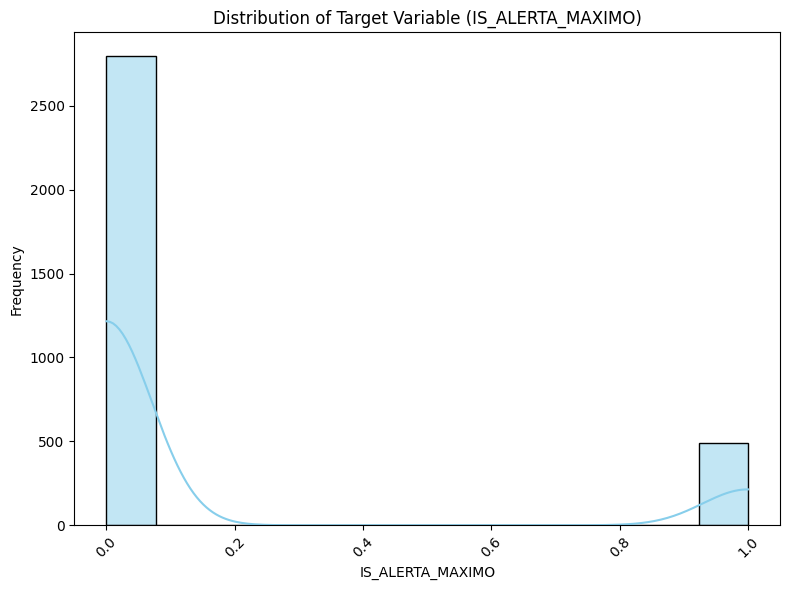

Saved target distribution plot to target_distribution.png


In [5]:
# 1. Distribution of the target variable
plt.figure(figsize=(8, 6))
if df[target_column].dtype == "object":
    sns.countplot(x=target_column, data=df, palette="viridis")
    plt.title(f"Distribution of Target Variable ({target_column})")
else:
    sns.histplot(df[target_column], kde=True, color="skyblue")
    plt.title(f"Distribution of Target Variable ({target_column})")
plt.xlabel(target_column)
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("target_distribution.png")
plt.show()
print("Saved target distribution plot to target_distribution.png")

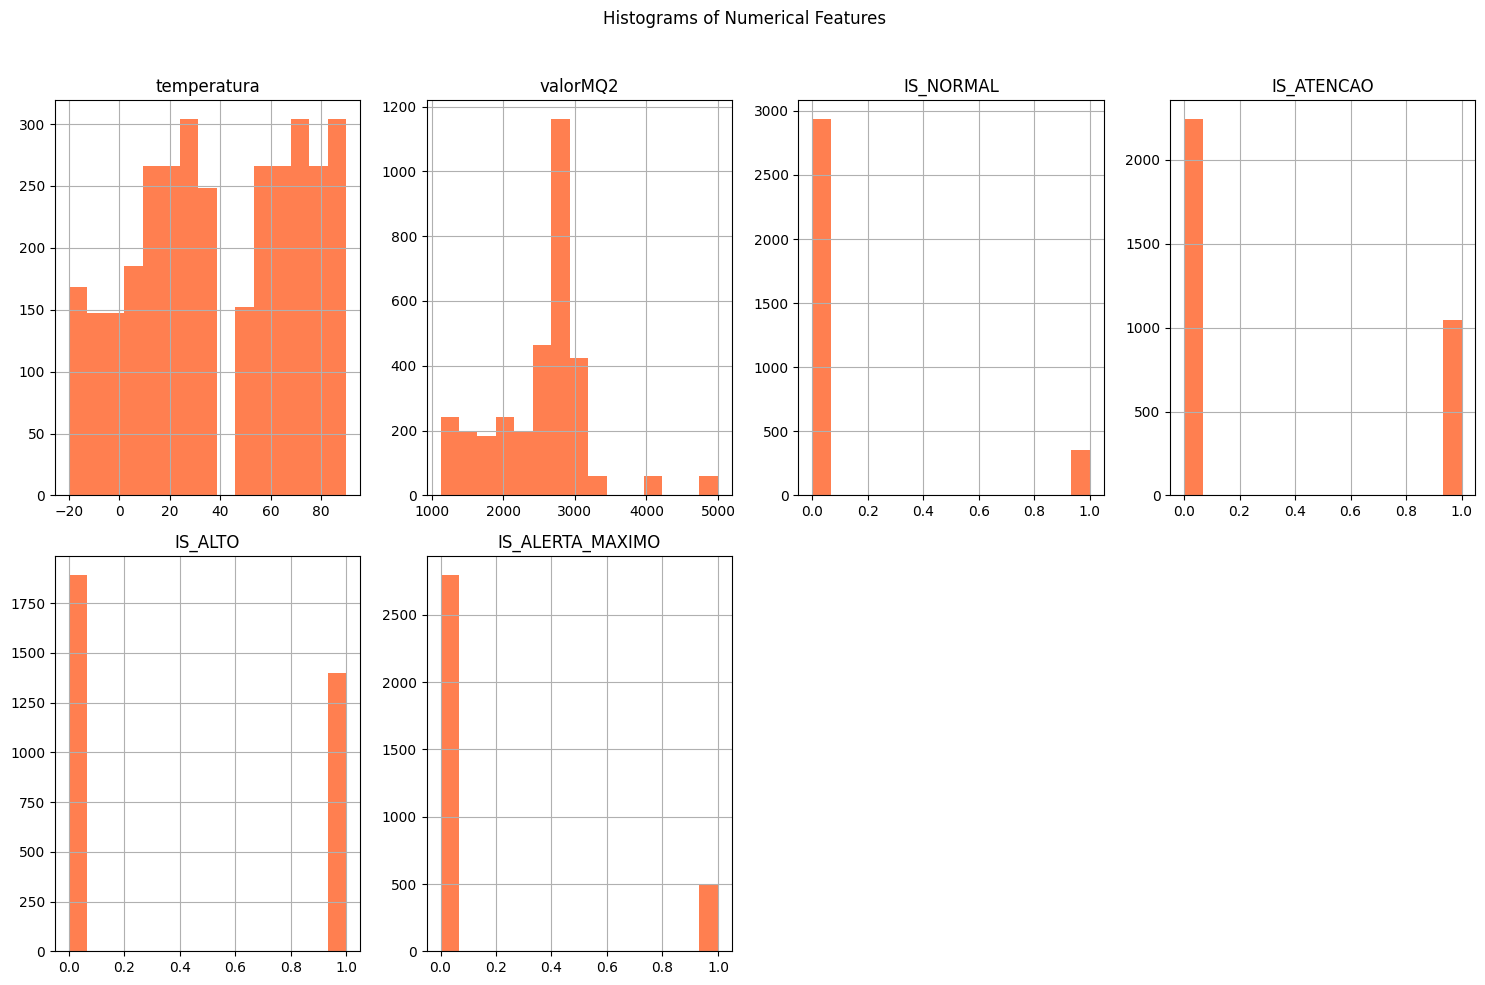

Saved numerical features histograms to numerical_features_histograms.png


In [6]:
# 2. Histograms for numerical features
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns
if target_for_model != target_column and target_for_model in numerical_features:
    numerical_features = numerical_features.drop(target_for_model)

if len(numerical_features) > 0:
    df[numerical_features].hist(
        bins=15, figsize=(15, 10), layout=(-1, 4), color="coral"
    )
    plt.suptitle("Histograms of Numerical Features")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("numerical_features_histograms.png")
    plt.show()
    print("Saved numerical features histograms to numerical_features_histograms.png")
else:
    print(
        "No numerical features found to plot histograms (excluding potentially encoded target)."
    )

In [8]:
# 3. Box plots for numerical features by target variable
if df[target_column].dtype == "object" and len(numerical_features) > 0:
    for feature in numerical_features:
        if feature != target_column and feature != target_for_model:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_column, y=feature, data=df, palette="pastel")
            plt.title(f"{feature} by {target_column}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"boxplot_{feature}_by_{target_column}.png")
            plt.show()
            print(
                f"Saved boxplot for {feature} to boxplot_{feature}_by_{target_column}.png"
            )
elif len(numerical_features) == 0:
    print("Skipping box plots as no numerical features were found.")
else:
    print(
        f"Skipping box plots by target as the target variable '{target_column}' is not categorical or no numerical features."
    )


Skipping box plots by target as the target variable 'IS_ALERTA_MAXIMO' is not categorical or no numerical features.


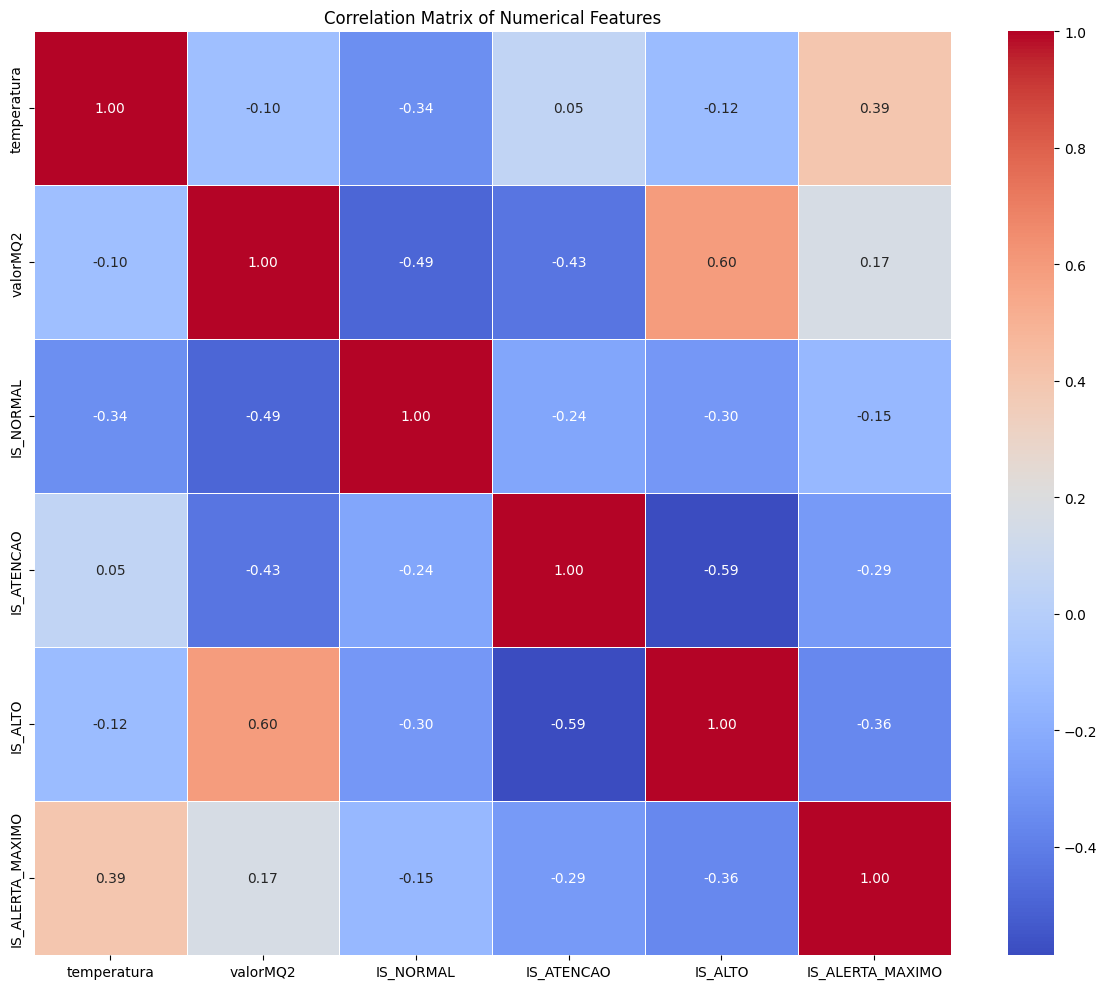

Saved correlation matrix heatmap to correlation_matrix.png


In [9]:
# 4. Correlation Matrix Heatmap
numeric_df_for_corr = df.select_dtypes(include=["number"])
if not numeric_df_for_corr.empty:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df_for_corr.corr()
    sns.heatmap(
        correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
    )
    plt.title("Correlation Matrix of Numerical Features")
    plt.tight_layout()
    plt.savefig("correlation_matrix.png")
    plt.show()
    print("Saved correlation matrix heatmap to correlation_matrix.png")
else:
    print("No numerical columns found to generate a correlation matrix.")

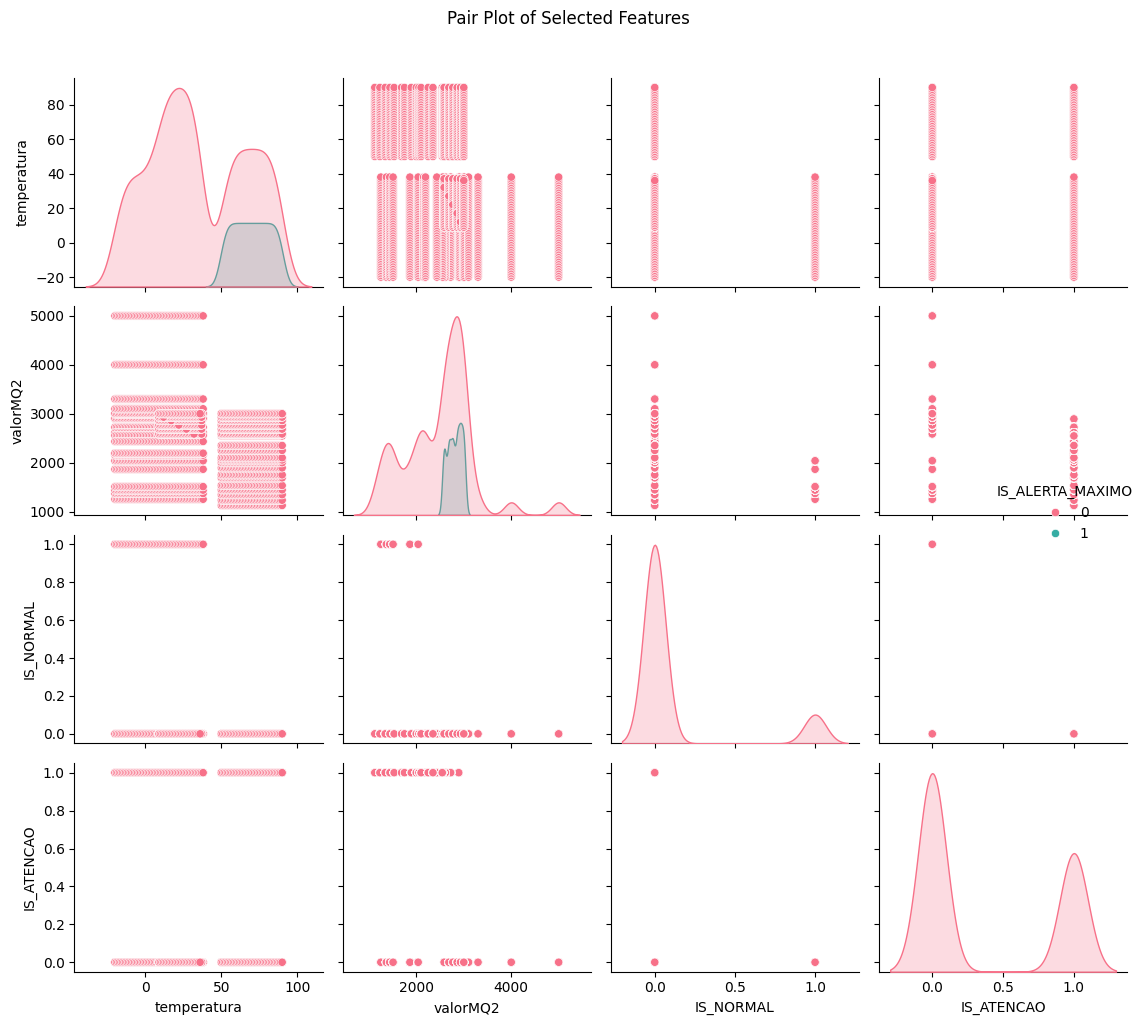

Saved pairplot to pairplot.png


In [10]:
# 5. Pairplot
if len(numerical_features) > 0:
    cols_for_pairplot = list(numerical_features[: min(4, len(numerical_features))])
    df_for_pairplot_data = df[
        cols_for_pairplot
    ].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Add target for hue if it's suitable
    target_for_hue = None
    if df[target_column].dtype == "object":
        target_for_hue = target_column
        df_for_pairplot_data[target_column] = df[target_column]
    elif (
        df[target_for_model].nunique() < 10
    ):  # If numerical target has few unique values, can be used for hue
        target_for_hue = target_for_model
        df_for_pairplot_data[target_for_model] = df[target_for_model]

    if target_for_hue:
        sns.pairplot(
            df_for_pairplot_data, hue=target_for_hue, palette="husl", diag_kind="kde"
        )
    else:
        sns.pairplot(df_for_pairplot_data, diag_kind="kde")

    plt.suptitle("Pair Plot of Selected Features", y=1.02)
    plt.tight_layout()
    plt.savefig("pairplot.png")
    plt.show()
    print("Saved pairplot to pairplot.png")
else:
    print("Skipping pairplot as no numerical features were found.")



# Processamento de dados para os modelos

In [11]:
print("\n## Data Preprocessing for Modeling ##")
X = df.drop(columns=[target_column, target_for_model], errors="ignore")
y = df[target_for_model]

print(f"\nFeatures (X) head:\n{X.head()}")
print(f"\nTarget (y) head:\n{y.head()}")

X = pd.get_dummies(X, drop_first=True)  # Handles categorical features in X
print(f"\nFeatures (X) after one-hot encoding head:\n{X.head()}")

if X.isnull().sum().sum() > 0:
    print(
        "\nWarning: NaN values found in features after preprocessing. Imputing with mean."
    )
    for col in X.columns:
        if X[col].isnull().any() and pd.api.types.is_numeric_dtype(X[col]):
            X[col] = X[col].fillna(X[col].mean())
if X.isnull().sum().sum() > 0:
    print(
        "Error: NaN values still present in features. Please check data cleaning steps."
    )
    exit()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Data Preprocessing for Modeling ##

Features (X) head:
   temperatura  valorMQ2  IS_NORMAL  IS_ATENCAO  IS_ALTO
0          -20      1251          1           0        0
1          -19      1251          1           0        0
2          -18      1251          1           0        0
3          -17      1251          1           0        0
4          -16      1251          1           0        0

Target (y) head:
0    0
1    0
2    0
3    0
4    0
Name: IS_ALERTA_MAXIMO, dtype: int64

Features (X) after one-hot encoding head:
   temperatura  valorMQ2  IS_NORMAL  IS_ATENCAO  IS_ALTO
0          -20      1251          1           0        0
1          -19      1251          1           0        0
2          -18      1251          1           0        0
3          -17      1251          1           0        0
4          -16      1251          1           0        0


# Treinando o modelo

In [12]:
print("\n## Model Training ##")
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42, probability=True),
}

trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} trained.")


## Model Training ##

Training K-Nearest Neighbors...
K-Nearest Neighbors trained.

Training Logistic Regression...
Logistic Regression trained.

Training Random Forest...
Random Forest trained.

Training Support Vector Machine...
Support Vector Machine trained.


# Avaliando o modelo


## Model Evaluation ##
Number of unique classes in target: 2. Using 'binary' averaging for recall and F1-score.

Evaluating K-Nearest Neighbors...
  Accuracy: 1.0000
  Recall (binary): 1.0000
  F1-score (binary): 1.0000
  Confusion Matrix:
[[560   0]
 [  0  98]]


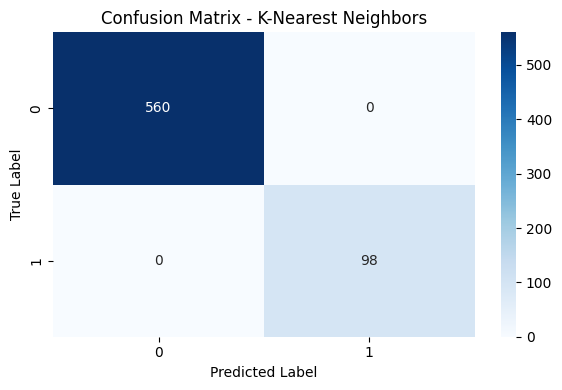

Saved confusion matrix for K-Nearest Neighbors to confusion_matrix_K-Nearest_Neighbors.png

Evaluating Logistic Regression...
  Accuracy: 1.0000
  Recall (binary): 1.0000
  F1-score (binary): 1.0000
  Confusion Matrix:
[[560   0]
 [  0  98]]


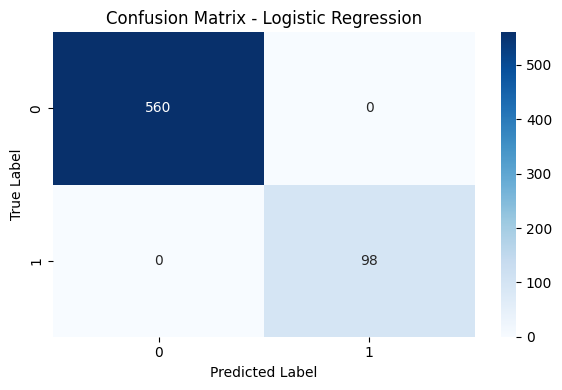

Saved confusion matrix for Logistic Regression to confusion_matrix_Logistic_Regression.png

Evaluating Random Forest...
  Accuracy: 1.0000
  Recall (binary): 1.0000
  F1-score (binary): 1.0000
  Confusion Matrix:
[[560   0]
 [  0  98]]


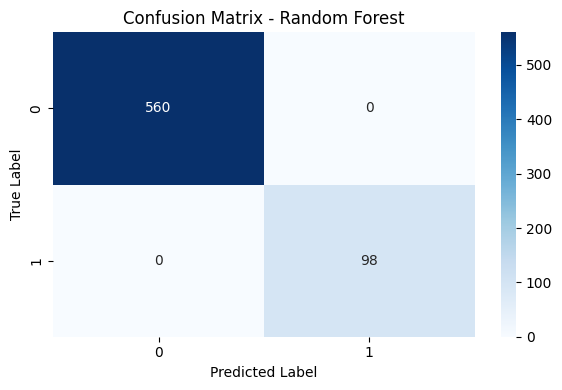

Saved confusion matrix for Random Forest to confusion_matrix_Random_Forest.png

Evaluating Support Vector Machine...
  Accuracy: 1.0000
  Recall (binary): 1.0000
  F1-score (binary): 1.0000
  Confusion Matrix:
[[560   0]
 [  0  98]]


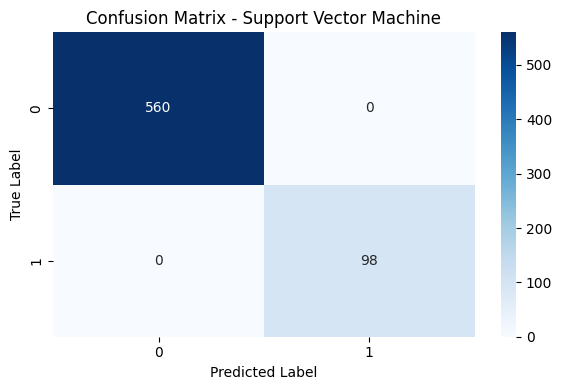

Saved confusion matrix for Support Vector Machine to confusion_matrix_Support_Vector_Machine.png


In [13]:
print("\n## Model Evaluation ##")
results = {}
num_classes = y.nunique()
average_method = "binary" if num_classes == 2 else "weighted"
print(
    f"Number of unique classes in target: {num_classes}. Using '{average_method}' averaging for recall and F1-score."
)

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average=average_method, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average_method, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        "Accuracy": accuracy,
        "Recall": recall,
        "F1-score": f1,
        "Confusion Matrix": cm,
    }
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Recall ({average_method}): {recall:.4f}")
    print(f"  F1-score ({average_method}): {f1:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=(
            le.classes_
            if "le" in globals()
            and hasattr(le, "classes_")
            and len(le.classes_) == num_classes
            else "auto"
        ),
        yticklabels=(
            le.classes_
            if "le" in globals()
            and hasattr(le, "classes_")
            and len(le.classes_) == num_classes
            else "auto"
        ),
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{name.replace(' ', '_')}.png")
    plt.show()
    print(
        f"Saved confusion matrix for {name} to confusion_matrix_{name.replace(' ', '_')}.png"
    )

In [14]:
# --- Summary of Results ---
print("\n## Summary of Model Performance ##")
results_df = pd.DataFrame(results).T
print(results_df[["Accuracy", "Recall", "F1-score"]])
print("\nScript finished successfully.")


## Summary of Model Performance ##
                       Accuracy Recall F1-score
K-Nearest Neighbors         1.0    1.0      1.0
Logistic Regression         1.0    1.0      1.0
Random Forest               1.0    1.0      1.0
Support Vector Machine      1.0    1.0      1.0

Script finished successfully.
